# ABS Monthly Consumer Price Index Indicator 6484

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-data-from-ABS" data-toc-modified-id="Get-data-from-ABS-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data from ABS</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot</a></span><ul class="toc-item"><li><span><a href="#Set-up-some-constants-we-will-use-across-all-plots" data-toc-modified-id="Set-up-some-constants-we-will-use-across-all-plots-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Set-up some constants we will use across all plots</a></span></li><li><span><a href="#Remove-the-old-charts" data-toc-modified-id="Remove-the-old-charts-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Remove the old charts</a></span></li><li><span><a href="#What-are-we-working-with" data-toc-modified-id="What-are-we-working-with-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>What are we working with</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Plot-growth---combined-line/bar-charts" data-toc-modified-id="Plot-growth---combined-line/bar-charts-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Plot growth - combined line/bar charts</a></span></li><li><span><a href="#Selected-sub-items" data-toc-modified-id="Selected-sub-items-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Selected sub items</a></span></li></ul></li><li><span><a href="#Finished" data-toc-modified-id="Finished-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Finished</a></span></li></ul></div>

## Python set-up

In [1]:
# system imports
import sys
import pathlib  
import calendar
import re

# analytic imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from typing import List, Dict

# local imports
from finalise_plot import finalise_plot
from abs_common import (
    get_fs_constants,
    get_plot_constants,
    get_ABS_meta_and_data,
    find_id,
    plot_growth2,
    clear_chart_dir,
)

# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# plotting stuff
plt.style.use('fivethirtyeight')

In [2]:
catalogue_id = '6484'
source, CHART_DIR, META_DATA = get_fs_constants(catalogue_id)
clear_chart_dir(CHART_DIR)

## Get data from ABS

In [3]:
# do the data capture and extraction to a DataFrame
abs_dict = get_ABS_meta_and_data(catalogue_id, verbose=False)
if abs_dict is None:
    sys.exit(-1)

Did not find the URL for a ZIP file
URL list of excel files identified
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...


## Plot

### Set-up some constants we will use across all plots

In [4]:
meta = abs_dict[META_DATA]
RECENT, plot_times, plot_tags = get_plot_constants(meta)

### Remove the old charts
We do this because the top expenditue item charts are uniquely named

In [5]:
for filename in pathlib.Path(CHART_DIR).glob("*.png"):
    filename.unlink()

### What are we working with

In [6]:
#meta

### Functions

In [7]:
def annualise_percentages(series:pd.Series, periods:int=12) -> pd.Series:
    """Annualise a growth rate for a period."""
    
    s = series / 100. 
    annual = (((1 + s) ** periods) - 1) * 100 
    return annual

### Plot growth - combined line/bar charts

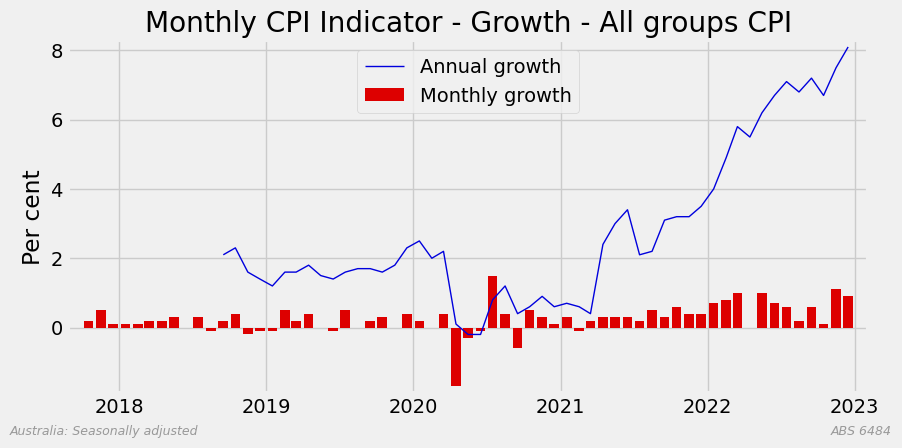

In [8]:
series_type = 'Seasonally Adjusted'
change = 'Percentage Change'
annual = 'Corresponding Month of Previous Year'
monthly = 'from Previous Period'
did_col = 'Data Item Description'
type_col = 'Series Type'
table_col = 'Table'

for series_name in ['All groups CPI', 'Trimmed Mean']:
    
    if not meta[did_col].str.contains(series_name).any():
        continue
    
    data = []
    for period in annual, monthly:
        selector = {
            series_type: type_col,
            period: did_col,
            series_name: did_col,
            change: did_col,
        }
        series_id, units = find_id(meta, selector, verbose=False)
        table = meta.loc[meta['Series ID'] == series_id, 'Table'].values[0]
        data.append(abs_dict[table][series_id])

    plot_growth2(
        data[0], data[1], 
        f'Monthly CPI Indicator - Growth - {series_name}', 
        None, 'annual-monthly', CHART_DIR,
        rfooter=f'{source}',
        lfooter=f'Australia: {series_type.capitalize()}',
        ppy=12, # four periods per year
        show=True
    )

### Selected sub items

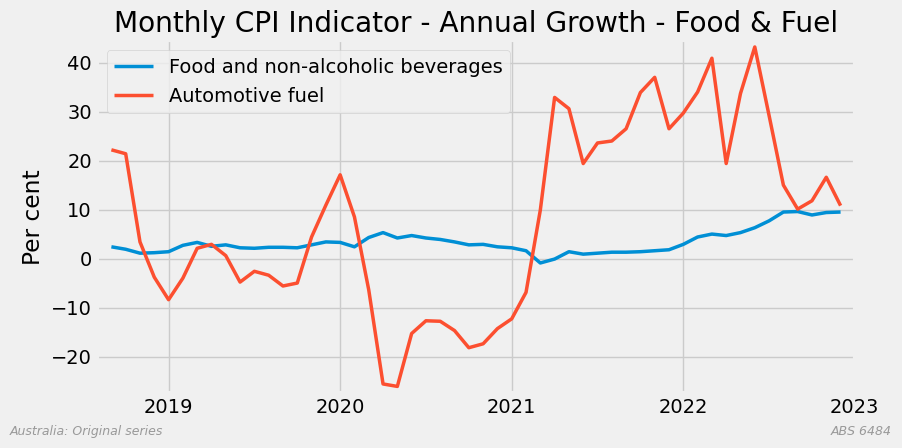

In [9]:
selectors ={
    'Food and non-alcoholic beverages': {
        'Food and non-alcoholic beverages': did_col,
        'Original': type_col,
        annual: did_col,
    },
    'Automotive fuel': {
        'Automotive fuel': did_col,
        'Original': type_col,
        annual: did_col,
    },
}

data = pd.DataFrame()
for name, selector in selectors.items():
    id, units = find_id(meta, selector, verbose=False)
    table = meta.loc[meta['Series ID'] == id, 'Table'].values[0]
    data[name] = abs_dict[table][id]
    
ax = data.dropna().plot(lw=2.5)
title = f'Monthly CPI Indicator - Annual Growth - Food & Fuel'
tag = '1'
series_type = 'Original series'
finalise_plot(
            ax, title, 
            'Per cent', 
            tag, CHART_DIR,
            rfooter=f'{source}',
            lfooter=f'Australia: {series_type}',
            show=True,
        )

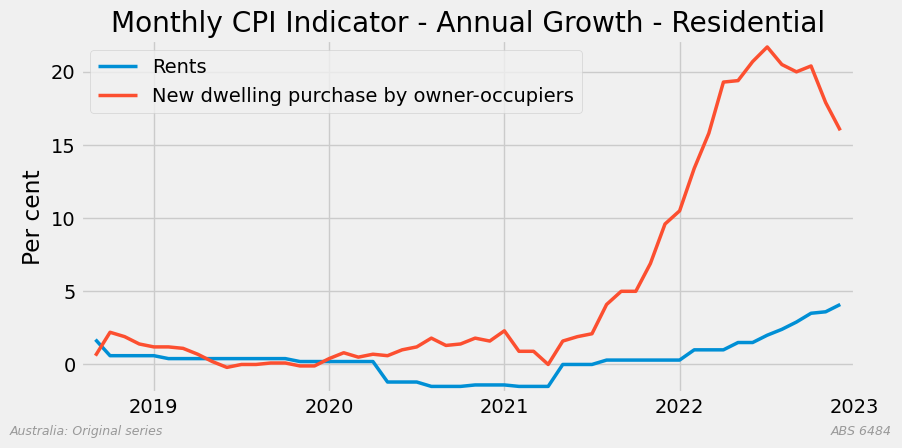

In [10]:
selectors ={
    'Rents': {
        'Rents': did_col,
        'Original': type_col,
        annual: did_col,
    },
    'New dwelling purchase by owner-occupiers': {
        'New dwelling purchase by owner-occupiers': did_col,
        'Original': type_col,
        annual: did_col,
    },
}

data = pd.DataFrame()
for name, selector in selectors.items():
    id, units = find_id(meta, selector, verbose=False)
    table = meta.loc[meta['Series ID'] == id, 'Table'].values[0]
    data[name] = abs_dict[table][id]
    
ax = data.dropna().plot(lw=2.5)
title = f'Monthly CPI Indicator - Annual Growth - Residential'
tag = '2'
series_type = 'Original series'
finalise_plot(
            ax, title, 
            'Per cent', 
            tag, CHART_DIR,
            rfooter=f'{source}',
            lfooter=f'Australia: {series_type}',
            show=True,
        )

## Finished

In [ ]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

In [11]:
print('Done')

Done
